In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil
import datetime 
from time import time
import re
from scipy import interpolate
import timeit
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR

import sys
sys.path.append("../")

from historical.readData.estimateData3 import read

from historical.readData.estimateData3 import read
from historical.readData.estimateData3 import search_travels
from historical.readData.estimateData3 import estimate
from historical.readData.estimateData3 import stops_distance

from historical.readData.travels3 import haversine2

def calcula_dist_shape(selec_linhas):
    distance_all_shapes = {}
    # print 'Calculando distancias dos shapes'
    '''calcula todas as distancias dos shapes'''
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"        
        
    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    
    for l, trip_id in enumerate(selec_linhas):

        trip = trips[trips.trip_id == trip_id]
        trip_shape = shapes[shapes['shape_id'].isin(trip['shape_id'])]
        shapelat = trip_shape.shape_pt_lat.tolist()
        shapelon = trip_shape.shape_pt_lon.tolist()

        # distancias dos shapes
        lon1 = shapelon[0]
        lat1 = shapelat[0]
        totalcal = [0.]
        dist = [0.]
        for lat2, lon2 in zip(shapelat[1:], shapelon[1:]):
            d = haversine2(lat1, lon1, lat2, lon2)
            d = d * 1000
            dist.append(d)
            totalcal.append(totalcal[-1] + d)
            lat1 = lat2
            lon1 = lon2
        distance_all_shapes[trip_id] = [shapelat, shapelon, totalcal]
    return distance_all_shapes

def stops_distance(linha):

    distances = calcula_dist_shape([linha])
    totalcal = distances[linha][2]
    
    pth_files_GTFS = "../historical/readData/dados/gtfs/"
    

    trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
    shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
    stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
    stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

    ida = trips[trips.trip_id == linha]
    shapeida = shapes[shapes['shape_id'].isin(ida['shape_id'])]
    idalat = shapeida.shape_pt_lat.tolist()
    idalon = shapeida.shape_pt_lon.tolist()
    total = shapeida.shape_dist_traveled.tolist()

    temp1 = stopid[stopid.trip_id == linha]
    stopsida = stops[stops['stop_id'].isin(temp1['stop_id'])]
    stopsida = stopsida.set_index('stop_id')
    stopsida = stopsida.reindex(index=temp1['stop_id'])

    stopslat = stopsida.stop_lat.tolist()
    stopslon = stopsida.stop_lon.tolist()

    dpontos = [None] * len(stopslat)
    index = 0
    lat = idalat
    lon = idalon
    total = 0
    p = ['depois'] * len(stopslat)
    for latb, lonb, i in zip(stopslat, stopslon, range(len(stopslat))):
        lat = lat[index:]
        lon = lon[index:]
        nn = haversine2(latb, lonb, np.array(lat), np.array(lon)) * 1000
        index = nn.argmin()
        total = total + index
        if index == 0:
            dpontos[i] = nn[index]
#            descontardist = nn[index]
        else:
            if totalcal[total] >= totalcal[total - 1] + nn[index - 1]:
                p[i] = 'antes'
            dpontos[i] = totalcal[total - 1] + nn[index - 1]

    mid_points = []
#    mid_points.append(200)
    p1 = dpontos[0]
    for p2 in dpontos[1:]:
        mid_points.append(p1 + (p2-p1)/2)
        p1 = p2
    dpontos = [i/1000. for i in dpontos]
    mid_points = [i/1000. for i in mid_points]
    # dpontos = [val-descontardist for val in dpontos]
    # stopsida.reset_index(drop=True, inplace=True)
    # stopsida['distancia'] = dpontos
    # stopsida.sort_values('distancia',axis=0,inplace=True)
    # stopsida.reset_index(drop=True, inplace=True)

    # gmap = gmplot.GoogleMapPlotter(idalat[0], idalon[0], 19)
    # gmap.marker(idalat[0],idalon[0], title='Test text')
    # gmap.plot(idalat, idalon, 'blue')
    # gmap.scatter(idalat, idalon, c='blue', size=10, marker=True, titles=totalcal)
    # gmap.scatter(stopsida['stop_lat'].tolist(), stopsida['stop_lon'].tolist(), c='red', size=10, marker=True,
    #             titles=["Ponto " + str(i + 1) + ": dist: " + str(stopsida['distancia'][i]) + ' ' + p[i] for i in
    #                     range(len(dpontos))])

    # gmap.draw('pontos.html')

    return dpontos, mid_points

def read(filedata,filerep):
    df0 = pd.read_pickle(filedata, compression=None)
    with open(filerep, 'rb') as handle:
        reps = pickle.load(handle, encoding='latin1')
    return df0, reps

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
        
def daterangeWD(start_date, end_date):
  return rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))

def hr_func(ts):
    return ts.hour

def minute_func(ts):
    return ts.minute

def second_func(ts):
    return ts.second

In [3]:

# if __name__ == '__main__':

selected_line = ['8700-10-1']

# '8700-10-0',
# selected_line = ['8700-10-1',                
#                 '7545-10-1',
#                 '7545-10-0',
#                 '6450-10-1',
#                 '6450-10-0',
#                 '3301-10-1',
# #                 '3301-10-0',
#                 '2290-10-1',
#                 '2290-10-0',
# #                 '574J-10-1',
# #                 '574J-10-0',
# #                 '477P-10-1',
#                 '477P-10-0',
# #                 '351F-10-1',
# #                 '351F-10-0'
#                 ]

pth_files_GTFS = "../historical/readData/dados/gtfs/"

trips = pd.read_csv(pth_files_GTFS + 'trips.txt', sep=',')
shapes = pd.read_csv(pth_files_GTFS + 'shapes.txt', sep=',')
stops = pd.read_csv(pth_files_GTFS + 'stops.txt', sep=',')
stopid = pd.read_csv(pth_files_GTFS + 'stop_times.txt', sep=',')   

periods = ['morning', 'm_peak', 'i_peak', 'a_peak', 'night']

line = selected_line[0]
p, mp = stops_distance(line)
pth_files_lines = "../historical/readData/"
df, reps = read(pth_files_lines + "trips_" + line + ".dsk", pth_files_lines + "interps_" + line + ".rep")


In [4]:
df['day'] = pd.to_datetime(df['day'], format = '%Y-%m-%d')
df['start'] = pd.to_datetime(df['start'], format = '%H:%M:%S')

df.loc[:,'exact_time'] = np.array(df['day'], dtype='datetime64[s]') + \
                       pd.to_timedelta(df['start'].apply(hr_func)*60 + \
                       df['start'].apply(minute_func) + \
                       df['start'].apply(second_func)/60 + \
                       df['time'], unit='m')

In [5]:
df['link'] = 0
for i in range(0, len(mp)-1):    
    df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < mp[i+1]),]['link'].index,'link'] = i    
#     df.loc[df.loc[(df['distance'] > mp[i]) & (df['distance'] < mp[i+1]),]['distance_link'].index,'distance_link'] = str(mp[i]) + '-' + str(mp[i+1])

df['day_hour'] = df['exact_time'].apply(hr_func)

***Seleção dos dados pro Treinamento***

In [13]:
start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2017, 7, 1)        

df_training = df.loc[(df['day'] < end_date) & (df['holiday'] != 1) & ((df['weekday'] != 6) | (df['weekday'] != 5))]


link_df = []
travels = sorted(list(set(df_training.numtravel.unique())))

/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


In [14]:
for tr in travels:
    tck = reps[tr][0]
    tck_mods = [(tck[0],tck[1]-m,tck[2]) for m in mp]       
    tempo = [a[0] if a.size>0 else np.nan for a in [interpolate.sproot(tck_mod) for tck_mod in tck_mods]]
    row = [tuple([tempo[i+1]-pos for i, pos in enumerate(tempo[:-1])])]    
    link_df.append(row)


In [29]:
link_df_np = np.array(link_df)
link_df_np.shape = (np.shape(link_df_np)[0], np.shape(link_df_np)[2])
link_df_pd = pd.DataFrame(link_df_np, index=travels)


3835    9.0
Name: 35, dtype: float64

Mean and Standard deviation of the link of the line 8700
=============

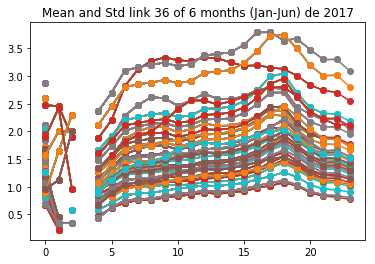

In [31]:
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR

# format = '%Y-%m-%d %H:%M:%S'
format = '%Y-%m-%d'

fig, (ax0) = plt.subplots(nrows=1, sharex=True)    
for link in range(0, len(mp) - 1):    
    
    mean_link = []
    std_link = []
    for day_hour in range(0, 24):        
        travels = df_training.loc[(df_training['day_hour'] == day_hour) & (df_training['link'] == link)]['numtravel'].unique()

        temp_link_info = link_df_pd.loc[travels][link]
        
        temp_link_info[temp_link_info > 5] = 2

        mean_link.append(temp_link_info[~np.isnan(temp_link_info)].mean())
        std_link.append(temp_link_info[~np.isnan(temp_link_info)].std())
        # example data
        x = range(0,len(mean_link))
        # example error bar values that vary with x-position
        ax0.errorbar(x, mean_link, fmt='-o')
ax0.set_title('Mean and Std link ' + str(link + 1) + ' of 6 months (Jan-Jun) de 2017')    
plt.show()

Temporal covariance of bus travels during 24 hours with a historical dataset of 6 months only working days
==========

/home/marcos/.local/lib/python3.6/site-packages/pandas/core/frame.py:6641: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


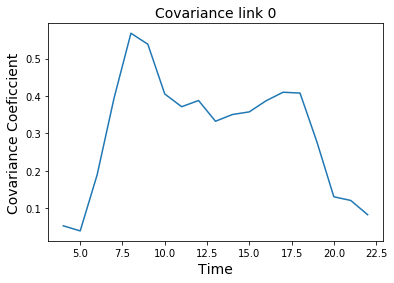

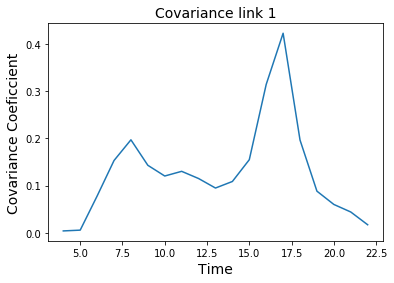

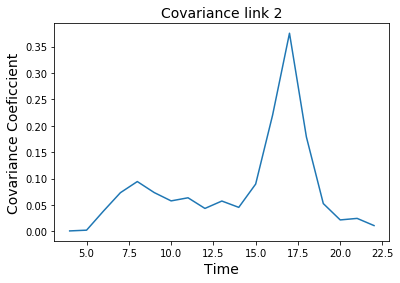

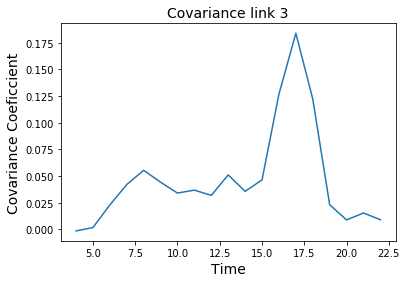

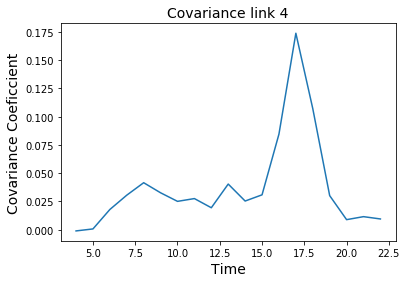

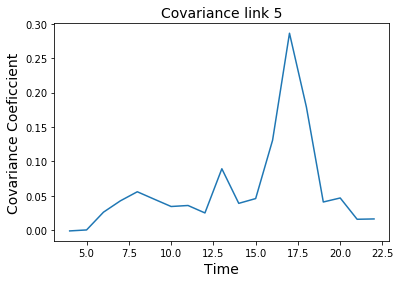

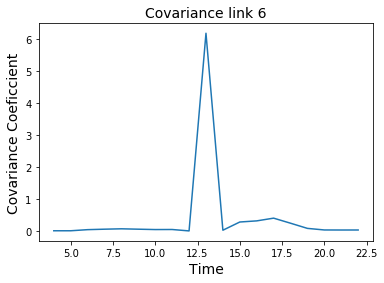

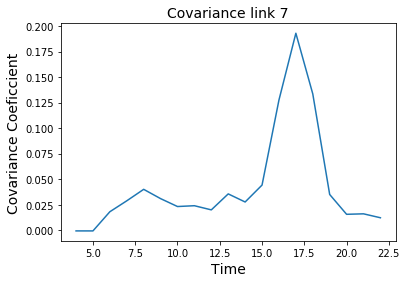

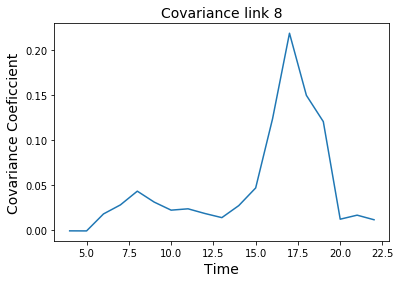

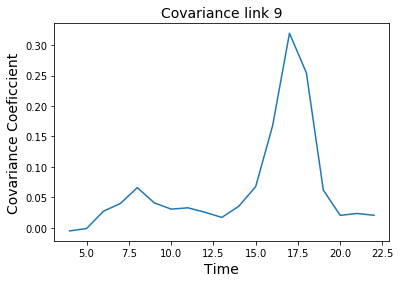

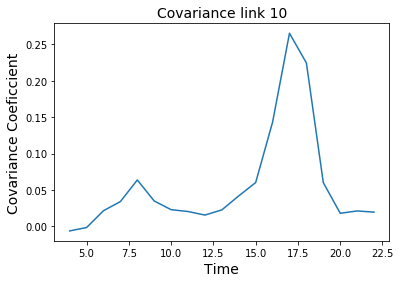

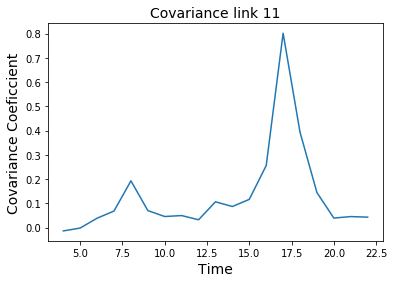

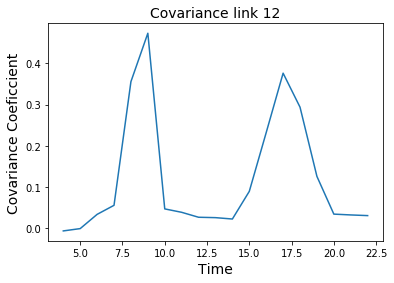

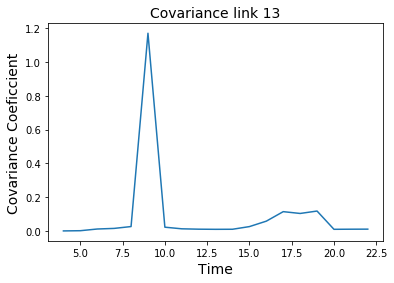

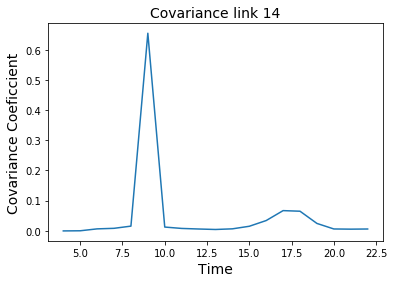

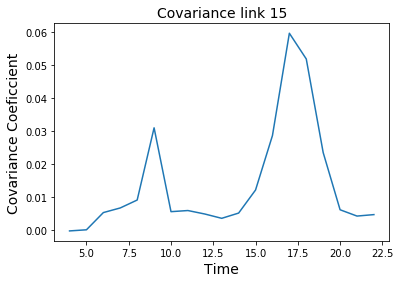

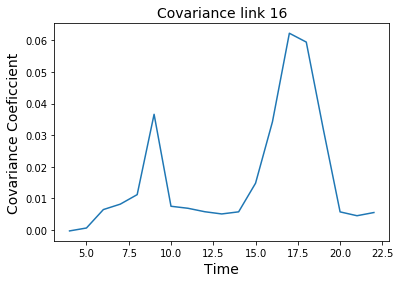

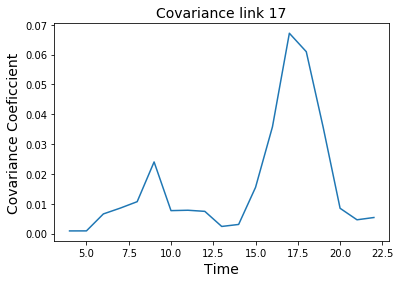

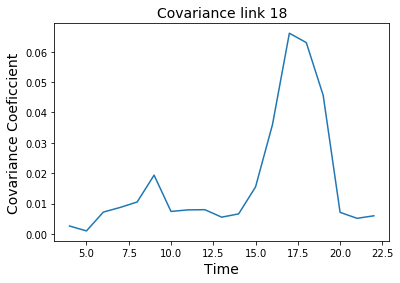

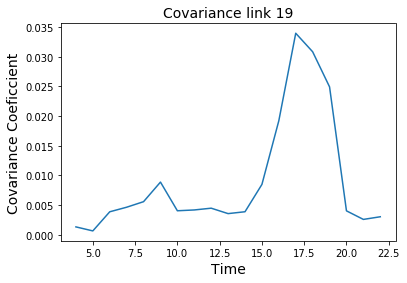

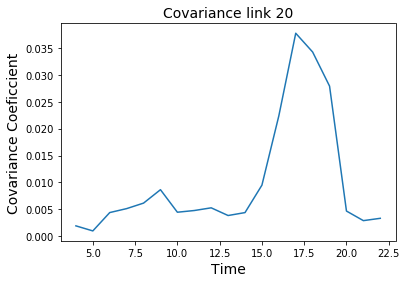

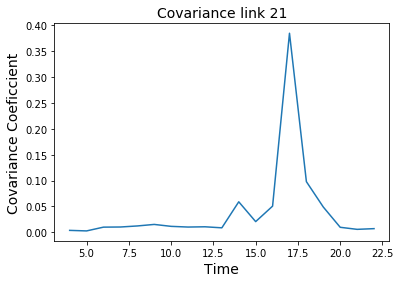

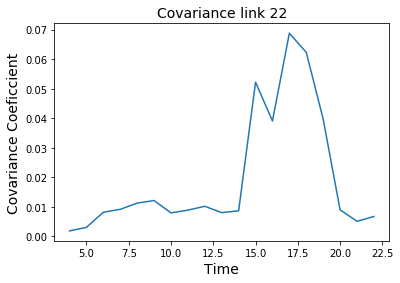

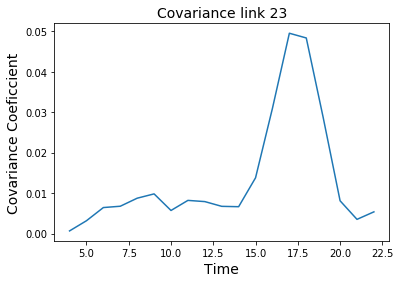

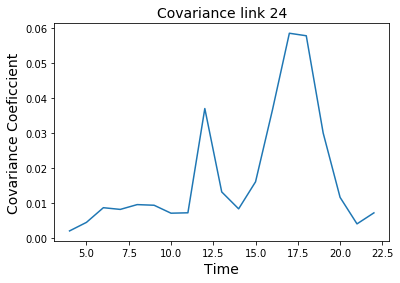

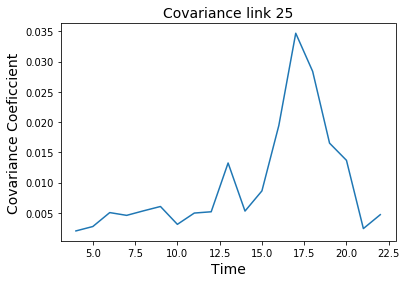

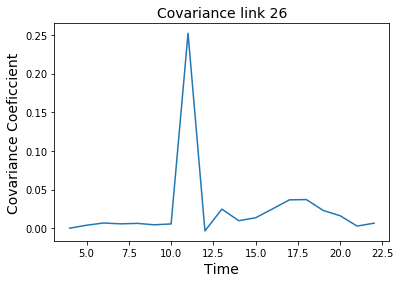

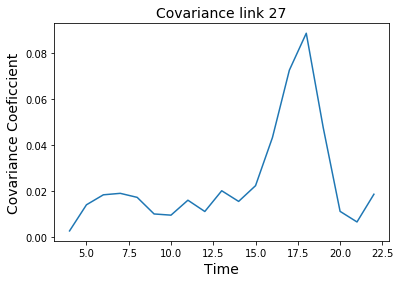

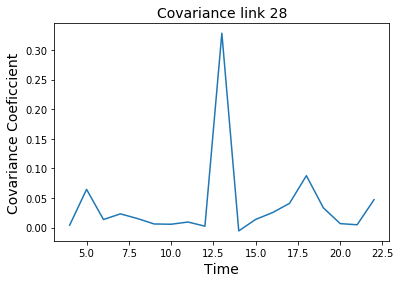

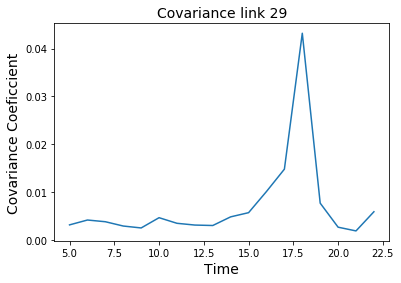

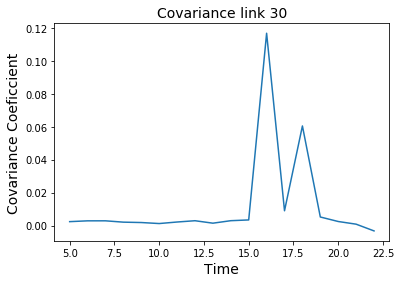

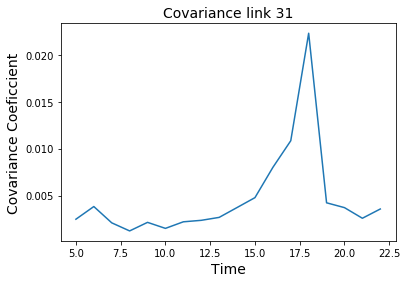

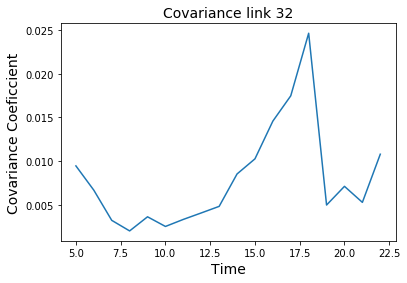

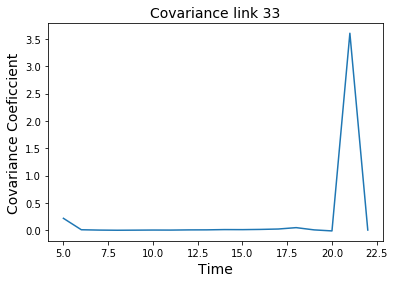

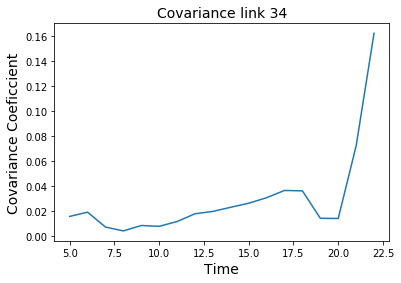

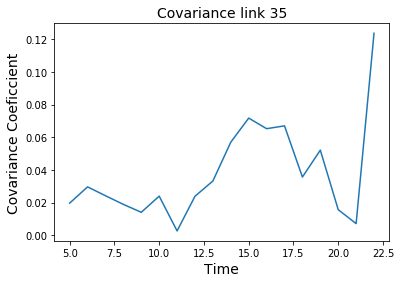

In [12]:


# format = '%Y-%m-%d %H:%M:%S'
format = '%Y-%m-%d'

    
for link in range(0, len(mp) - 1):    
    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    cov_link = []
    
    for day_hour in range(0, 23):
        temp_link_info = []
        for single_date in df_training.day.unique():
            selected_day = single_date
            
            travels = df_training.loc[(df_training['day'] == selected_day) &\
                              (df_training['day_hour'] == day_hour) &\
                              (df_training['link'] == link)]['numtravel'].unique()            
    
            travels_later = df_training.loc[(df_training['day'] == selected_day) &\
                              (df_training['day_hour'] == day_hour + 1) &\
                              (df_training['link'] == link)]['numtravel'].unique()            
    
            temp_link_info.append([np.mean(link_df_pd.loc[travels][link]), np.mean(link_df_pd.loc[travels_later][link])])        
    
        cov_link.append(pd.DataFrame(temp_link_info).dropna().cov()[0][1])
            
    plt.plot(cov_link)
    plt.title('Covariance link ' + str(link),fontsize=14)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Covariance Coeficcient',fontsize=14)
    plt.show()


Spatial convariance of bus travels during 24 hours with a historical dataset of 9 working days
=======

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/marcos/.local/lib/python3.6/site-packages/pandas/core/frame.py:6641: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


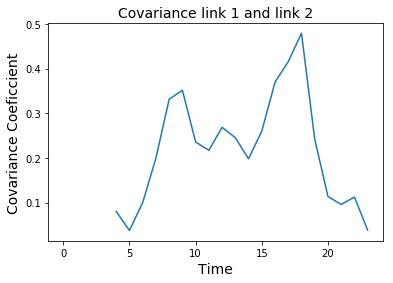

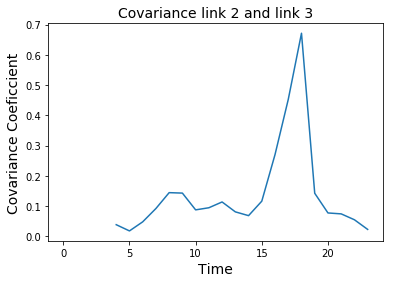

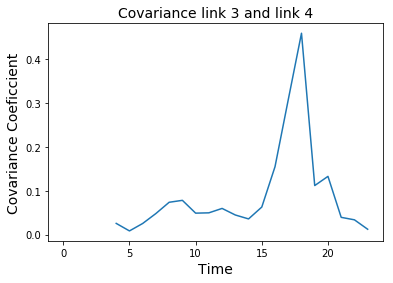

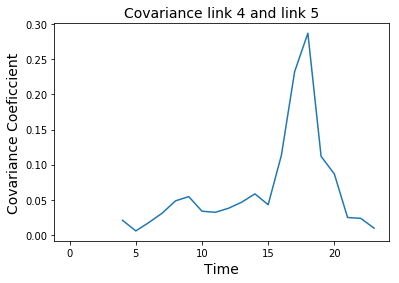

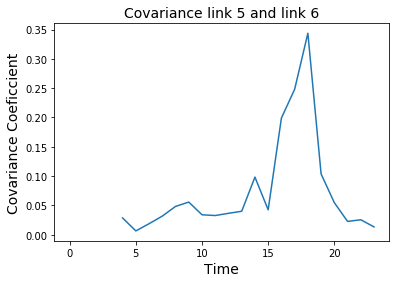

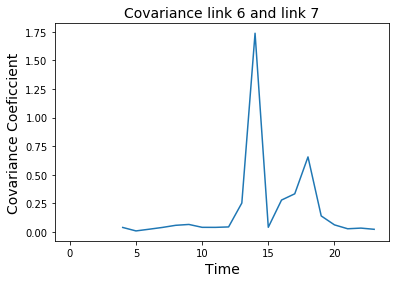

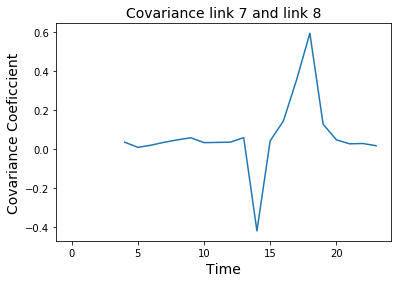

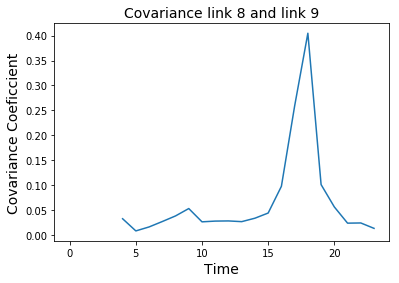

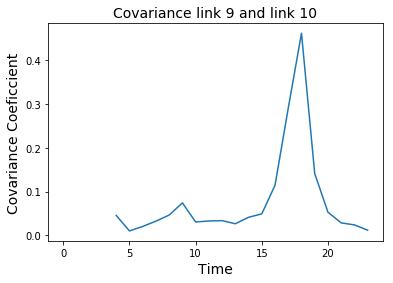

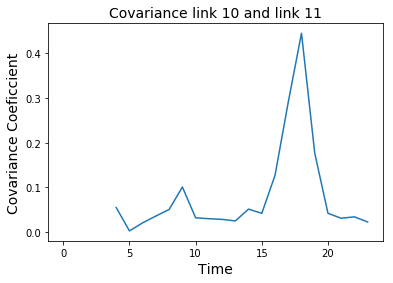

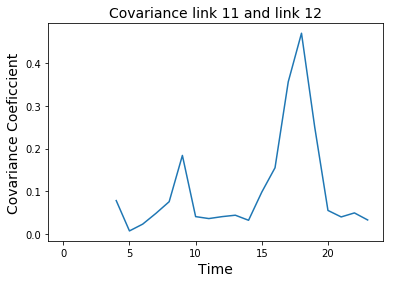

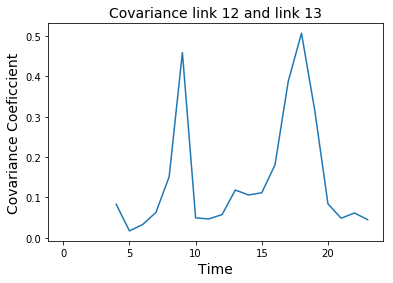

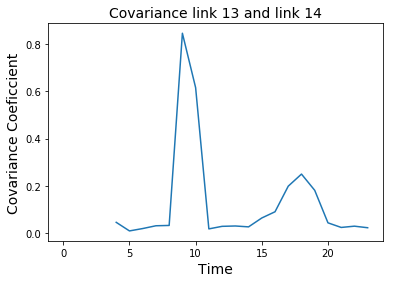

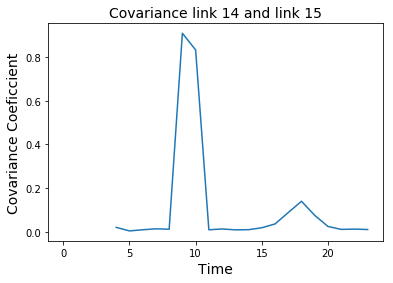

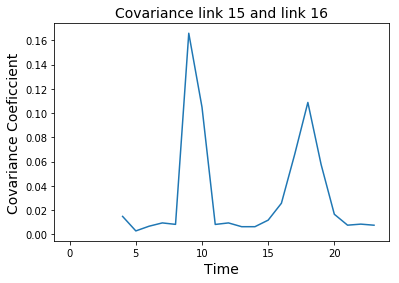

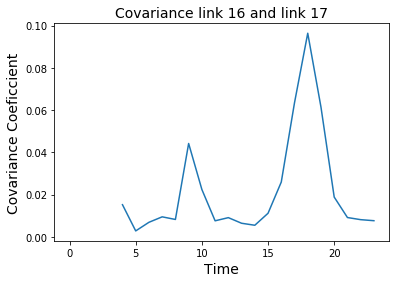

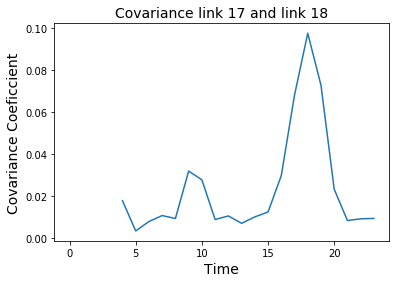

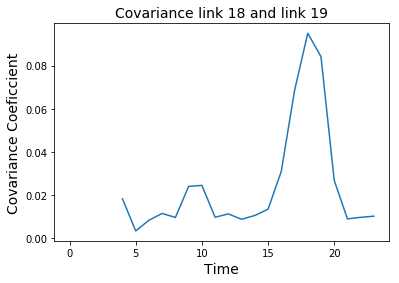

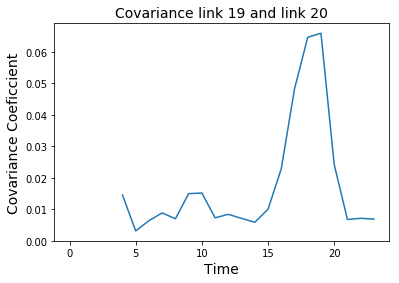

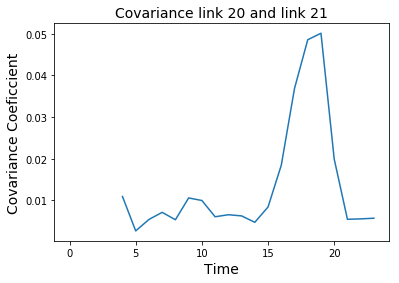

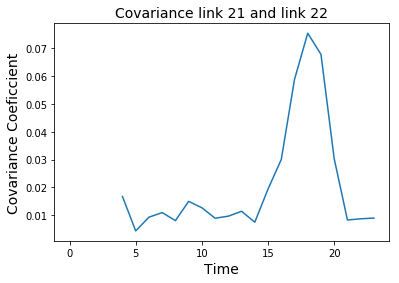

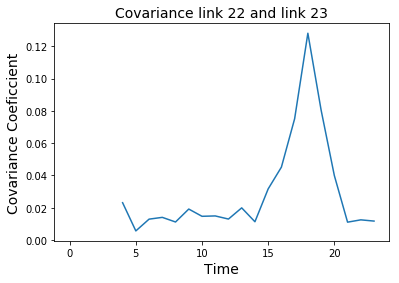

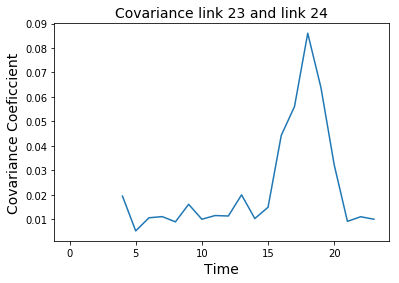

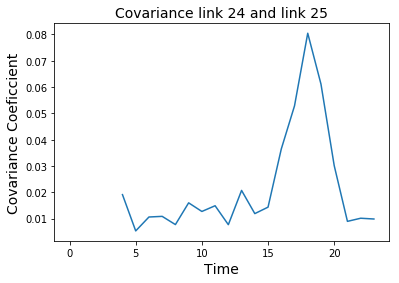

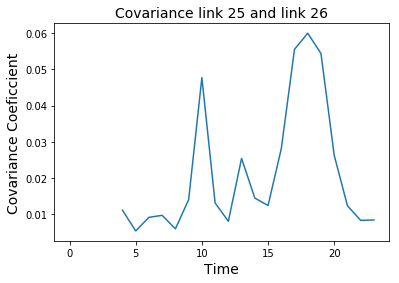

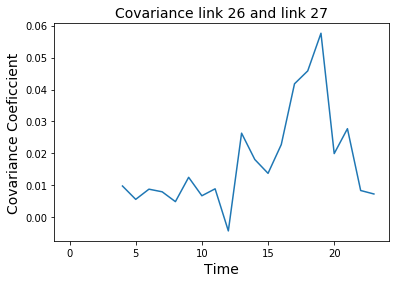

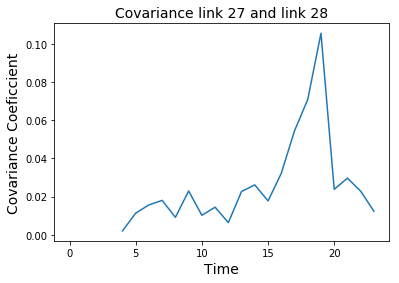

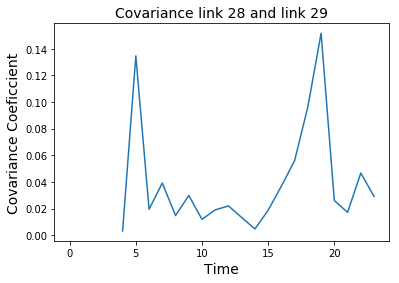

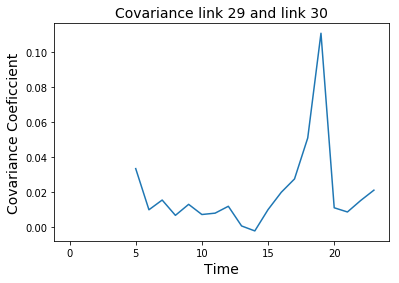

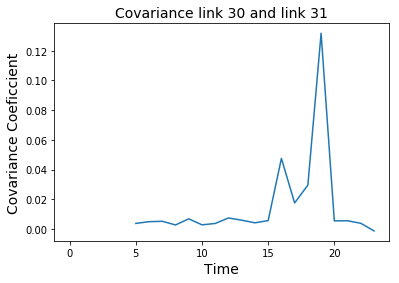

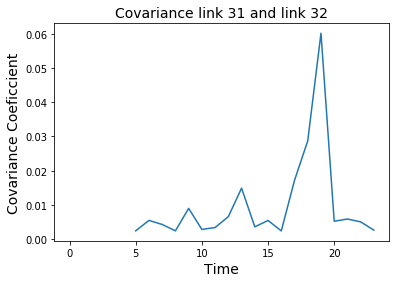

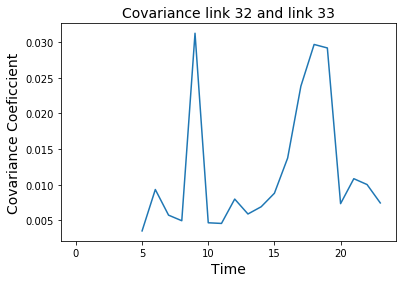

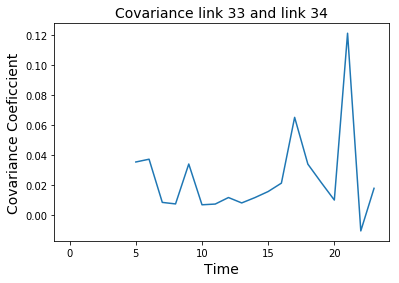

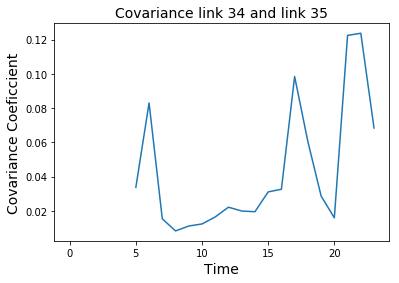

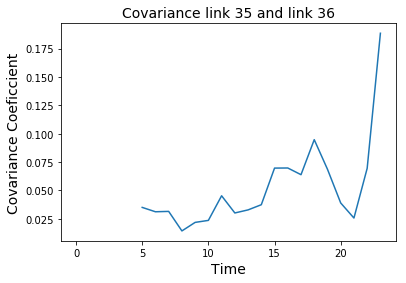

In [17]:
for link in range(0, 35):    
    fig, (ax0) = plt.subplots(nrows=1, sharex=True)
    
    cov_link = []
    for day_hour in range(0, 24):
        temp_link_info = []
        for single_date in df_training.day.unique():
            selected_day = single_date
            
            travels = df_training.loc[(df_training['day'] == selected_day) &\
                              (df_training['day_hour'] == day_hour) &\
                              (df_training['link'] == link)]['numtravel'].unique()            
    
            travels_after = df_training.loc[(df_training['day'] == selected_day) &\
                              (df_training['day_hour'] == day_hour) &\
                              (df_training['link'] == link + 1)]['numtravel'].unique()            
    
            temp_link_info.append([np.mean(link_df_pd.loc[travels][link]), np.mean(link_df_pd.loc[travels_after][link + 1])])        
    
        cov_link.append(pd.DataFrame(temp_link_info).dropna().cov()[0][1])
            
#         cov_link.append(np.cov(temp_link_info, temp_link_after_info, bias=True)[0][1])
        
        
    plt.plot(cov_link)
    plt.title('Covariance link ' + str(link + 1) + ' and link ' + str(link + 2),fontsize=14)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Covariance Coeficcient',fontsize=14)    
    plt.show()


In [ ]:
%matplotlib notebook  
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# pd.set_option('html',False)
# pd.set_option('max_columns',30)
# pd.set_option('max_rows',10)


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

# def randrange(n, vmin, vmax):
#     return (vmax-vmin)*np.random.rand(n) + vmin

# fig = plt.figure()
# ax = fig.add_subplot(111, p4rojection='3d')
# n = 1000
# for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
#     xs = np.linspace(0, 36, n)
#     ys = np.linspace(0, 24, n)
#     zs = randrange(n, xs, zh)
#     ax.scatter(xs, ys, zs, c=c, marker=m)

# ax.set_xlabel('Stop buses')
# ax.set_ylabel('Time')
# ax.set_zlabel('Covariance')
# ax.mouse_init()

# plt.show()


# mpl.rcParams['legend.fontsize'] = 10

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
# z = np.linspace(-2, 2, 100)
# r = z**2 + 1
# x = np.linspace(0, 36, 100)
# y = np.linspace(0, 24, 100)
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()

# plt.show()
# df.groupby([df['exact_time'],pd.TimeGrouper(freq='30Min')])
# help(pd.TimeGrouper)
# df.groupby( [ "Name", "City"] ).count()
# df.loc[df['day'] >= '2017-01-01']
#           list(d)
# df.groupby(['day_hour', 'link', 'numtravel']).agg(lambda x: ','.join(x))


# type(temp)

%matplotlib notebook  
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# pd.set_option('html',False)
# pd.set_option('max_columns',30)
# pd.set_option('max_rows',10)


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

# def randrange(n, vmin, vmax):
#     return (vmax-vmin)*np.random.rand(n) + vmin

# fig = plt.figure()
# ax = fig.add_subplot(111, p4rojection='3d')
# n = 1000
# for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
#     xs = np.linspace(0, 36, n)
#     ys = np.linspace(0, 24, n)
#     zs = randrange(n, xs, zh)
#     ax.scatter(xs, ys, zs, c=c, marker=m)

# ax.set_xlabel('Stop buses')
# ax.set_ylabel('Time')
# ax.set_zlabel('Covariance')
# ax.mouse_init()

# plt.show()


# mpl.rcParams['legend.fontsize'] = 10

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
# z = np.linspace(-2, 2, 100)
# r = z**2 + 1
# x = np.linspace(0, 36, 100)
# y = np.linspace(0, 24, 100)
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()

# plt.show()
# df.groupby([df['exact_time'],pd.TimeGrouper(freq='30Min')])
# help(pd.TimeGrouper)
# df.groupby( [ "Name", "City"] ).count()
# df.loc[df['day'] >= '2017-01-01']
#           list(d)
# df.groupby(['day_hour', 'link', 'numtravel']).agg(lambda x: ','.join(x))


#####################################################################################

# start_time = timeit.default_timer()

# for time_hour in range(24):


# link_df = pd.DataFrame(link_df, index = travels)        
# for numtravel in travels:
#     for link in range(0, len(mp)-1):
#         df.loc[df[(df['numtravel'] == numtravel) & (df['link'] == link)].index,'time_link'] = link_df.iloc[numtravel, link]
# # np.unique(df[['numtravel', 'link', 'time_link']])
# timeit.default_timer() - start_time

# df[(df.numtravel >= 0) & (df.link == 0)]
# link_df
# len(link_df_np[35])

# df[df.numtravel == [0, 1]]
# df.loc[df.link == 0 ]
link_df_np = np.array(link_df)
link_df_np.shape = (36, 42566)
# np.mean([0, 6,8,9,5, 'nan'])



A[~np.isnan(A)].std()


